# TD4 - Explainability AI

#### Matias OTTENSEN
#### Tiphaine KACHKACHI
#### Manon GARDIN

# Our dataset 

Petite description du dataset

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sklearn
from sklearn.datasets import load_diabetes

In [4]:
df = pd.read_csv('US_Accidents_March23.csv', sep=',')

## Observe data

In [5]:
df.shape

(7728394, 46)

We have a great number of lines in our dataset.\
Also we have 46 columns, we probably won't need every one of them. Let's see their name :

In [6]:
df.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [7]:
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

As the dataframe is huge (almost 3 gb), we decided to work on another version of this dataframe, just to have a sample that we could work on esier:

In [10]:
halfsize=int((df.shape[0])/2)
df_half= df.iloc[:halfsize,:]
print(df_half.shape)


(3864197, 46)


Variables like Street, City, Zipcode and County won't be useful to keep, because there are too many distinct values.\
The columns Bump, Traffic_calming, Turning_loop, Give_Way, No_Exit, Roundabout can be deleted because they take only one value (all false).\
The variable Country only takes US so we can delete it.\
We can also delete some columns like Airport_Code that won't be relevant.

In [11]:
# Delete the columns we don't need 
df_half = df_half.drop(['Street', 'City', 'Description','County', 'Zipcode', 'Country', 'Bump', 'Traffic_Calming', 'Turning_Loop', 'Give_Way', 'No_Exit', 'Roundabout', 'Airport_Code'], axis=1)

In [12]:
df_half.head(10)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,False,True,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,False,True,Day,Day,Day,Day
5,A-6,Source2,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
6,A-7,Source2,2,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
7,A-8,Source2,3,2016-02-08 07:59:58,2016-02-08 08:29:58,39.770382,-84.194901,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
8,A-9,Source2,2,2016-02-08 08:00:40,2016-02-08 08:30:40,39.778061,-84.172005,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
9,A-10,Source2,3,2016-02-08 08:10:04,2016-02-08 08:40:04,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day


In [13]:
df_half.info

<bound method DataFrame.info of                 ID   Source  Severity           Start_Time  \
0              A-1  Source2         3  2016-02-08 05:46:00   
1              A-2  Source2         2  2016-02-08 06:07:59   
2              A-3  Source2         2  2016-02-08 06:49:27   
3              A-4  Source2         3  2016-02-08 07:23:34   
4              A-5  Source2         2  2016-02-08 07:39:07   
...            ...      ...       ...                  ...   
3864192  A-3893182  Source1         2  2022-06-01 12:09:00   
3864193  A-3893183  Source1         2  2022-04-13 16:38:44   
3864194  A-3893184  Source1         2  2023-01-19 12:10:00   
3864195  A-3893185  Source1         2  2022-03-09 08:34:00   
3864196  A-3893186  Source1         2  2022-02-12 20:32:00   

                    End_Time  Start_Lat  Start_Lng    End_Lat    End_Lng  \
0        2016-02-08 11:00:00  39.865147 -84.058723        NaN        NaN   
1        2016-02-08 06:37:59  39.928059 -82.831184        NaN        Na

# Question 3

The variables we can predict are probably the severity of an accident, and maybe a start time.

Based on our intuition, we think that the most important variables to predict the severity of an accident would be the weather condition variables like Humidity, Wind Speed, Pressure, etc. And probably the time of the day like Day or Night.

## Univariate Analysis

In [14]:
df_half.describe

<bound method NDFrame.describe of                 ID   Source  Severity           Start_Time  \
0              A-1  Source2         3  2016-02-08 05:46:00   
1              A-2  Source2         2  2016-02-08 06:07:59   
2              A-3  Source2         2  2016-02-08 06:49:27   
3              A-4  Source2         3  2016-02-08 07:23:34   
4              A-5  Source2         2  2016-02-08 07:39:07   
...            ...      ...       ...                  ...   
3864192  A-3893182  Source1         2  2022-06-01 12:09:00   
3864193  A-3893183  Source1         2  2022-04-13 16:38:44   
3864194  A-3893184  Source1         2  2023-01-19 12:10:00   
3864195  A-3893185  Source1         2  2022-03-09 08:34:00   
3864196  A-3893186  Source1         2  2022-02-12 20:32:00   

                    End_Time  Start_Lat  Start_Lng    End_Lat    End_Lng  \
0        2016-02-08 11:00:00  39.865147 -84.058723        NaN        NaN   
1        2016-02-08 06:37:59  39.928059 -82.831184        NaN        

# Data Cleaning

Missing values:

In [117]:
print(df.isnull().sum())

ID                             0
Source                         0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                        0
End_Lng                        0
Distance(mi)                   0
Description                    0
Street                         0
City                           0
County                         0
State                          0
Zipcode                        0
Country                        0
Timezone                       0
Airport_Code                   0
Weather_Timestamp              0
Temperature(F)                 0
Wind_Chill(F)                  0
Humidity(%)                    0
Pressure(in)              140679
Visibility(mi)            177098
Wind_Direction            175206
Wind_Speed(mph)           571233
Precipitation(in)        2203586
Weather_Condition         173459
Amenity                        0
Bump      

There are missing values, so, what can we do about it?

First, we create a new dataframe to secure the first one if we ever delete the wring values

In [42]:
newdf= df

In [130]:
#for the end lat/lng : we will fill the NAN by the start lat/lng:

newdf['End_Lat']=newdf['End_Lat'].fillna(newdf['Start_Lat'])
newdf['End_Lng']=newdf['End_Lng'].fillna(newdf['Start_Lng'])

#for the streets/Cities/Description/zipcode/timezone/Weather_Condition/Sunrise_Sunset/Civil_Twilight/Nautical_Twilight
#and Astronomical_Twilight, we just write "unknown", 
#as we do not want to give fake infoomations to the person reading

newdf['Street']=newdf['Street'].fillna('unknown')
newdf['City']=newdf['City'].fillna('unknown')
newdf['Description']=newdf['Description'].fillna('unknown')
newdf['Zipcode']=newdf['Zipcode'].fillna('unknown')
newdf['Timezone']=newdf['Timezone'].fillna('unknown')
newdf['Weather_Condition']=newdf['Weather_Condition'].fillna('unknown')
newdf['Sunrise_Sunset']=newdf['Sunrise_Sunset'].fillna('unknown')
newdf['Civil_Twilight']=newdf['Civil_Twilight'].fillna('unknown')
newdf['Nautical_Twilight']=newdf['Weather_Condition'].fillna('unknown')
newdf['Astronomical_Twilight']=newdf['Astronomical_Twilight'].fillna('unknown')



# for the airport code, we write '####' in the missing values
newdf['Airport_Code']=newdf['Airport_Code'].fillna('####')


# for the weather timestamp, we put now's date
newdf['Weather_Timestamp']=newdf['Weather_Timestamp'].fillna(datetime.now())

#for the temperature, we need to convert the data, as it is an object type :
newdf['Temperature(F)'] = pd.to_numeric(newdf['Temperature(F)'], errors='coerce')
#temperature/Wind_Chill(F)/Humidity(%)/Pressure(in)/Visibility(mi)/Wind_Speed(mph)/Precipitation(in): we put the mean
newdf['Temperature(F)']=newdf['Temperature(F)'].fillna(newdf['Temperature(F)'].mean())
newdf['Wind_Chill(F)']=newdf['Wind_Chill(F)'].fillna(newdf['Wind_Chill(F)'].mean())
newdf['Humidity(%)']=newdf['Humidity(%)'].fillna(newdf['Humidity(%)'].mean())
newdf['Pressure(in)']=newdf['Pressure(in)'].fillna(newdf['Pressure(in)'].mean())
newdf['Visibility(mi)']=newdf['Visibility(mi)'].fillna(newdf['Visibility(mi)'].mean())
newdf['Wind_Speed(mph)']=newdf['Wind_Speed(mph)'].fillna(newdf['Wind_Speed(mph)'].mean())
newdf['Precipitation(in)']=newdf['Precipitation(in)'].fillna(newdf['Precipitation(in)'].mean())


# for the airport code, we write '###' in the missing values
newdf['Wind_Direction']=newdf['Wind_Direction'].fillna('###')




In [142]:
print(newdf.isnull().sum())

ID                       0
Source                   0
Severity                 0
Start_Time               0
End_Time                 0
Start_Lat                0
Start_Lng                0
End_Lat                  0
End_Lng                  0
Distance(mi)             0
Description              0
Street                   0
City                     0
County                   0
State                    0
Zipcode                  0
Country                  0
Timezone                 0
Airport_Code             0
Weather_Timestamp        0
Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
S

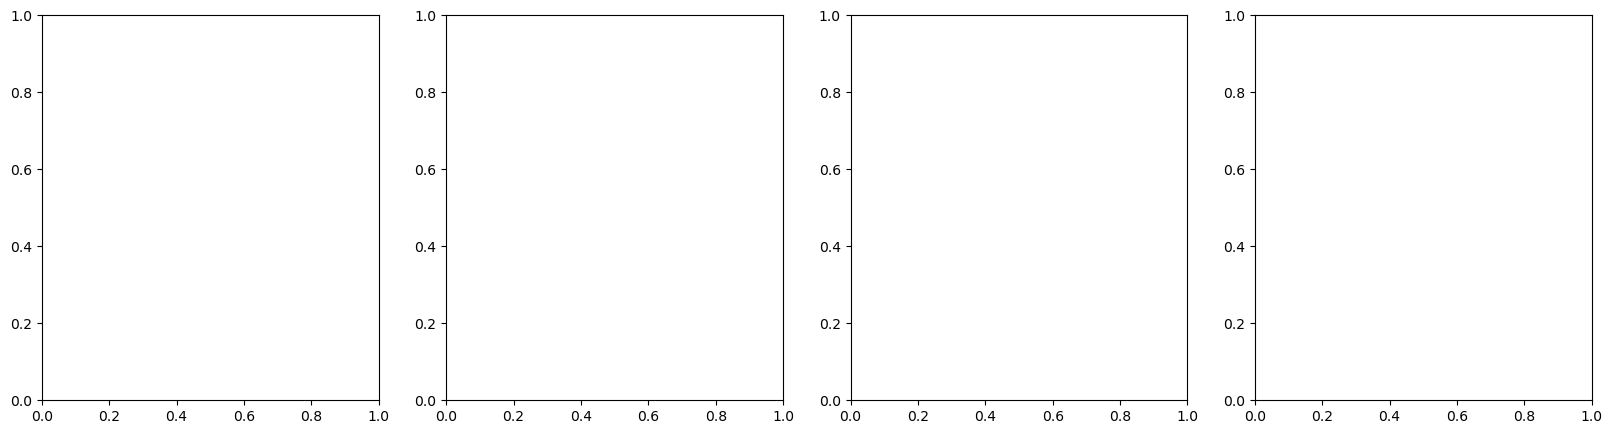

In [151]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

<Axes: >

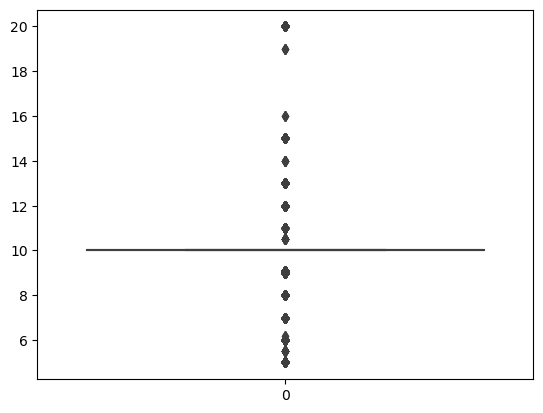

In [160]:
sns.boxplot(newdf['Visibility(mi)'])

Looks like there is a lot of outliers, so we decide to replace some outliers withe the mean value

<Axes: >

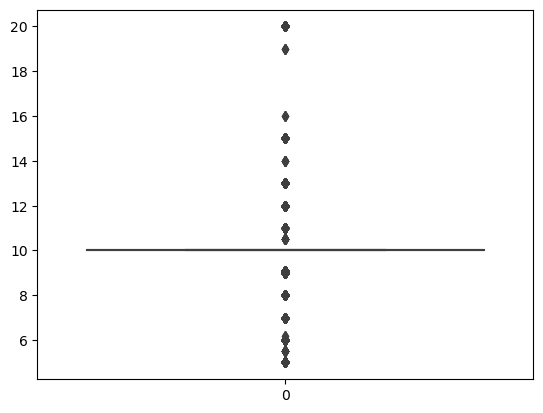

In [157]:
moyenne_colonne = df['Visibility(mi)'].mean()

df.loc[df['Visibility(mi)'] > 20, 'Visibility(mi)'] = moyenne_colonne

df.loc[df['Visibility(mi)'] < 5, 'Visibility(mi)'] = moyenne_colonne

sns.boxplot(newdf['Visibility(mi)'])

As we can see, actually, there is a huge amount of "10" values, so the other values are more rare, but are not outliers for this, so we can keep the data this way for this one 

In [ ]:
Q1= newdf['Visibility(mi)'].quantile(0.25)
print(Q1)
Q3= newdf['Visibility(mi)'].quantile(0.75)
print(Q3)
IQR = Q3 - Q1
print(IQR)

# CONTINUE HERE 
ce qu'il y a en bas c'est la suite, ce qu'il faudra faire après le data cleaning 

Let's do a histogram

In [35]:
halfsize2=int((df_half.shape[0])/4)
df_half2= df.iloc[:halfsize2,:]

df_half2.shape[0]

966049

(array([ 38375.,      0.,      0., 584192.,      0.,      0., 340664.,
             0.,      0.,   2818.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

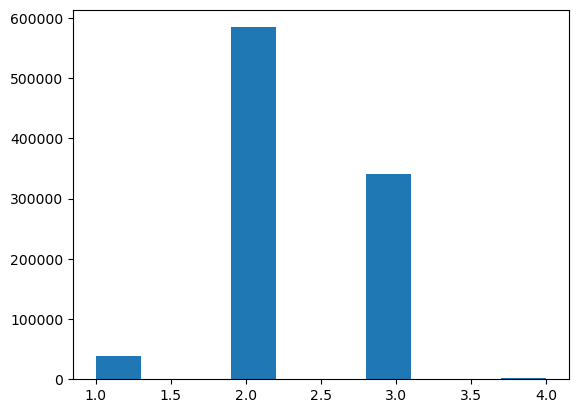

In [36]:
plt.hist(df_half2['Severity'])

In [158]:
#plt.hist(df_half2['Sunrise_Sunset'])

In [159]:
#plt.scatter(df.index,df['Start_Time'])
#plt.show()